In [198]:
import numpy as np
import matplotlib.pyplot as plt
import random

cards_type = ['A','2','3','4','5','6','7','8','9','10','J','Q','K']
cards_scores = [1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  10, 10, 10]
num_cards_type = 13

def calc_total_score(cards):
    total_score = 0
    has_ace = False
    for card in cards:
        total_score += cards_scores[card]
        if card == 0:
            has_ace = True
    if has_ace and total_score <= 11:
        return total_score + 10, True
    else:
        return total_score, False



def blackjack_episode(policy):
    states = np.zeros((10,2),dtype=int)#player score from 13 to 21, or bust (score > 21)
    actions = np.zeros(10,dtype=int)
    rewards = np.zeros(10,dtype=float)
    #rhos = np.zeros((10,2),dtype=float)

    dealer_cards = [1, random.choice(range(num_cards_type))]
    player_cards = [0, 1]
    dealer_score,_ = calc_total_score(dealer_cards)
    player_score, usable_ace = calc_total_score(player_cards)
    showing_card = cards_scores[dealer_cards[0]]

    state = (player_score - 13, usable_ace)
    states[0] = state
    
    step = 0
    while True:
        action = np.random.choice(2,p=policy[state[0]])
        if action == 1:
            break
        player_cards.append(random.choice(range(num_cards_type)))
        player_score, usable_ace = calc_total_score(player_cards)
        state = (player_score - 13 if player_score <= 21 else 9, usable_ace)
        step += 1
        states[step] = state

    actions[step] = 1
    if player_score > 21:
        rewards[step] = -1
    else:    
        while dealer_score < 17:
            dealer_cards.append(random.choice(range(num_cards_type)))
            dealer_score,_ = calc_total_score(dealer_cards)
        
        if dealer_score > 21:
            rewards[step] = 1
        else:
            if player_score < dealer_score:
                rewards[step] = -1
            elif player_score > dealer_score:
                rewards[step] = 1
            else:
                rewards[step] = 0
    
    return states[:step+1],actions[:step+1],rewards[:step+1]

def monte_carlo(num_episodes):
    pi_probs = np.zeros((10,2),dtype=float)
    b_probs = np.zeros((10,2),dtype=float)
    for n in range(7):
        pi_probs[n] = (1.0, 0.0)
    for n in range(7,10):
        pi_probs[n] = (0.0,1.0)
    for n in range(8):
        b_probs[n] = (0.5, 0.5)
    for n in range(8,10):
        b_probs[n] = (0.0,1.0)

    probs = pi_probs
    values = np.zeros((10,2),dtype=float)
    counts = np.zeros((10,2),dtype=int)
    for n in range(num_episodes):
        states, actions, rewards = blackjack_episode(probs)
        accesses = np.zeros((10,2),dtype=bool)
        g = 0.0
        len = rewards.size
        for t in range(len-1,-1,-1):
            g += rewards[t]
            state = states[t]
            action = actions[t]
            index = (state, action)
            if not accesses[index]:
                accesses[index] = True
                counts[index] += 1
                values[index] += (g - values[index])/counts[index]
    return values


def monte_carlo_off_policy(num_episodes):
    random.seed(1000)
    pi_probs = np.zeros((10,2),dtype=float)
    b_probs = np.zeros((10,2),dtype=float)
    for n in range(7):
        pi_probs[n] = (1.0, 0.0)
    for n in range(7,10):
        pi_probs[n] = (0.0,1.0)
    for n in range(8):
        b_probs[n] = (0.5, 0.5)
    for n in range(8,10):
        b_probs[n] = (0.0,1.0)
    values = np.zeros((10,2),dtype=float)
    rhos = np.zeros((10,2),dtype=float)
    vs = np.zeros((10,2),dtype=float)
    cs = np.zeros((10,2),dtype=float)
    counts = np.zeros((10,2),dtype=int)
    for n in range(num_episodes):
        accesses = np.zeros((10,2,2),dtype=bool)
        states, actions, rewards = blackjack_episode(b_probs)
        g = 0.0
        acc_pi = 1.0
        acc_b = 1.0
        len = rewards.size
        for t in range(len-1,-1,-1):
            g += rewards[t]
            state = states[t]
            player_score, usable_ace = state
            index = (player_score, usable_ace)
            action = actions[t]
            rho = acc_pi/acc_b
            if not accesses[player_score, usable_ace, action]:
                accesses[player_score, usable_ace, action] = True
                counts[index] += 1
                values[index] += (g*rho - values[index])/counts[index]
                rhos[index] += (rho - rhos[index])/counts[index]
                if rho != 0:
                    cs[index] += rho
                    vs[index] += (g - vs[index])*rho/cs[index]

            acc_pi *= pi_probs[player_score,action]
            acc_b *= b_probs[player_score,action]
    return values, np.where(rhos == 0, 0, values/rhos), vs

def monte_carlo_off_policy_2(num_episodes):
    random.seed(1000)
    pi_probs = np.zeros((10,2),dtype=float)
    b_probs = np.zeros((10,2),dtype=float)
    for n in range(7):
        pi_probs[n] = (1.0, 0.0)
    for n in range(7,10):
        pi_probs[n] = (0.0,1.0)
    for n in range(8):
        b_probs[n] = (0.5, 0.5)
    for n in range(8,10):
        b_probs[n] = (0.0,1.0)
    values = np.zeros((10,2,2),dtype=float)
    rhos = np.zeros((10,2,2),dtype=float)
    vs = np.zeros((10,2,2),dtype=float)
    cs = np.zeros((10,2,2),dtype=float)
    counts = np.zeros((10,2,2),dtype=int)
    for n in range(num_episodes):
        accesses = np.zeros((10,2,2),dtype=bool)
        states, actions, rewards = blackjack_episode(b_probs)
        g = 0.0
        acc_pi = 1.0
        acc_b = 1.0
        len = rewards.size
        for t in range(len-1,-1,-1):
            g += rewards[t]
            state = states[t]
            action = actions[t]
            player_score, usable_ace = state
            index = (player_score, usable_ace, action)
            rho = acc_pi/acc_b
            if not accesses[index]:
                accesses[index] = True
                counts[index] += 1
                values[index] += (g*rho - values[index])/counts[index]
                rhos[index] += (rho - rhos[index])/counts[index]
                if rho != 0:
                    cs[index] += rho
                    vs[index] += (g - vs[index])*rho/cs[index]

            acc_pi *= pi_probs[player_score,action]
            acc_b *= b_probs[player_score,action]
    return values, np.where(rhos == 0, 0, values/rhos), vs
        

/tmp/ipykernel_3260/2595762440.py:187: RuntimeWarning: invalid value encountered in divide
  return values, np.where(rhos == 0, 0, values/rhos), vs


(array([1.40522351, 1.62568951, 1.28274502, 1.24684915, 0.97437231,
        1.24824503, 1.31130149, 0.81629629, 0.86056793, 0.63096468,
        0.30089063, 0.19994652, 0.16472183, 0.17902509, 0.15470199,
        0.12821382, 0.11332718, 0.073693  , 0.09216336, 0.04991022,
        0.02734573, 0.01566672, 0.01249803, 0.00988951, 0.01084263,
        0.0087566 , 0.00905429, 0.00720655]),
 array([0.48104831, 0.39896071, 0.41224036, 0.69044442, 0.68519598,
        0.60737889, 0.61965605, 0.65548551, 0.6462336 , 0.57650291,
        0.24209668, 0.16279257, 0.12215506, 0.14234118, 0.11214267,
        0.09179897, 0.11658023, 0.06758646, 0.07690783, 0.04572941,
        0.02443508, 0.01379886, 0.01053811, 0.00786494, 0.00996361,
        0.00760367, 0.00736255, 0.00631344]))

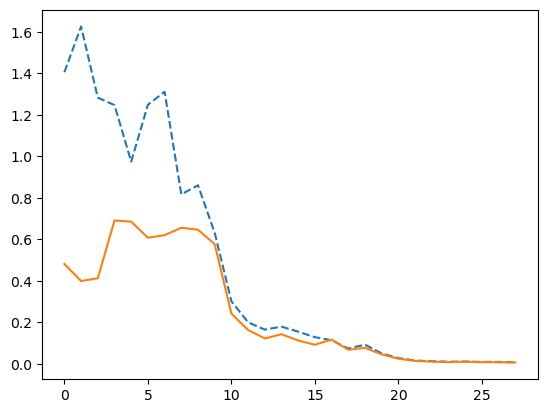

In [201]:
#values = monte_carlo(1000000)
#print(values)

mean = -0.27726
episodes = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
num_test = len(episodes)
mses1 = np.zeros(num_test)
mses2 = np.zeros(num_test)
for n in range(num_test):
    episode = episodes[n]#1 << n#pow(1.5,n)
    mse1 = 0
    mse2 = 0
    for m in range(100):
        values, weighting_values, weighting_values2 = monte_carlo_off_policy_2(episode)
        dis1 = values[0,1,0] - mean
        mse1 += dis1 * dis1
        dis2 = weighting_values2[0,1,0] - mean
        mse2 += dis2 * dis2
    mses1[n] = mse1/100
    mses2[n] = mse2/100

plt.plot(range(num_test), mses1, '--')
plt.plot(range(num_test), mses2)
mses1,mses2

#values, weighting_values, weighting_values2 = monte_carlo_off_policy_2(10000)
#values[:,1,0], weighting_values[:,1,0], weighting_values2[:,1,0]
#values[:,1,1], weighting_values[:,1,1], weighting_values2[:,1,1]

